In [3]:
import os
import simu_process.simulation as sim
from tools.generate_config import gen_config
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from tools.utils import get_root_path
from matplotlib.lines import Line2D

In [2]:
def simulate_get_output(config_list):
    """
    run simulations and generate config files with different alpha values
    @param config_list: list of paths of config files
    @return: a list of all output files
    """
    output_files = []
    for config in config_list:
        # print(f'Run the simulations with config file: {config}')
        simu = sim.Simulation(config)
        simu.run_and_save()
        output = simu.output_file
        output_files.append(output)
    return output_files


def concat_results(output_files):
    """
    get results data from output files for further analysis
    @param output_files: a list out output files
    @return: user_all and cc_all, general results of the files
    """
    if not output_files:
        print('Warning, no file paths in input')
        return []
    else:
        u_list = []
        cc_list = []
        for i in output_files:
            # find alpha value
            alpha = i[i.find('alpha')+5: i.find('_23')]
            rs_basic = i[i.find('_output/')+8:i.find('_alpha')]
            # print(alpha)
            with open(i, 'rb') as file:
                loaded_data = pickle.load(file)
                user_df = loaded_data[0]
                # print(len(user_df))
                cc_df = loaded_data[1]
                user_df['alpha'] = alpha
                cc_df['alpha'] = alpha
                user_df['rs'] = rs_basic
                cc_df['rs'] = rs_basic
                u_list.append(user_df)
                cc_list.append(cc_df)
        user_all = pd.concat(u_list).reset_index(drop=True)
        # print(user_all.columns)
        cc_all = pd.concat(cc_list)
        cc_all['avg_view'] = cc_all['view']/(cc_all['frequency']+1)/12
        return [user_all, cc_all]

## Preprocess
In this part, we run the simulations and pre-process the output files of the simulations

In [5]:
# If already run all the simulations, skip this cell
# TODO: run all simulation in one run
base_file = 'config.yaml'
value = 'alpha'
value_list = [-1000, -50, -10, -5, -2.5, -1, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1, 2.5, 5, 10, 50, 1000]
bs_list = ['avg_views'] #, 'total_views', 'total_avg_views', 'subscribers']
# get the file names of the config files
config_list = gen_config(base_file,bs_list, value, value_list)

# run simulation and get output paths
# The default recommendation basic is average_view, to get results with other basics, you have to change the parameter in config.yaml and rerun the cells above.
output_files = simulate_get_output(config_list)

Simulations 'avg_views' with alpha = 1000: 100%|██████████| 100/100 [08:09<00:00,  4.89s/it]


In [4]:
####### to do analysis based on existing outputs
# After get all results for simulations with varies RSs.
root_dir = get_root_path()
output_path = os.path.join(root_dir, '_output')
file_names = os.listdir(output_path)
avg_view_files = [i for i in file_names if i[:9]=='avg_views']
total_avg_view_files = [i for i in file_names if i[:15]=='total_avg_views']
total_view_files = [i for i in file_names if i[:11]=='total_views']
validate_files = [i for i in file_names if i[:11]=='subscribers']

avg_view_output_files = [os.path.join(output_path, file_name) for file_name in avg_view_files]
total_avg_view_output_files = [os.path.join(output_path, file_name) for file_name in total_avg_view_files]
total_view_output_files = [os.path.join(output_path, file_name) for file_name in total_view_files]
validate_output_files = [os.path.join(output_path, file_name) for file_name in validate_files]

In [5]:
res_avg_view = concat_results(avg_view_output_files)
res_total_avg_view = concat_results(total_avg_view_output_files)
res_total_view = concat_results(total_view_output_files)
res_validate = concat_results(validate_output_files)

## Analysis of user satisfaction

In [25]:
# TODO: delete this
def user_searching_proportion(res):
    """
    Get the proportion of users stop searching (find the best CCs) at each step
    @param res: results of the simulation model, a list of [user_all, cc_all]
    @return: dataframe with alpha, step, and proportion of users finish searching
    """
    all_counts = res[0].groupby('alpha')['id'].count()
    steps_counts = res[0].groupby(['alpha', 'steps'])['id'].count()
    ratios = steps_counts.div(all_counts, level='alpha').reset_index()
    ratios['proportion'] = ratios.groupby('alpha')['id'].cumsum()
    return ratios


def simu_stop_proportion(user_all, step_list):
    """
    get proportion of simulations stop at each step
    @param step_list: [1, 10, 20, 50, 200, 900] the threshold of steps
    @param user_all: dataframe of user results
    @return: dataframe with alpha, step, and proportion of iterations finished at the step
    """
    max_steps = user_all.groupby(['alpha', 'iteration'])['steps'].max().reset_index()

    result = []
    for step_threshold in step_list:
        step_counts = max_steps[max_steps['steps'] <= step_threshold].groupby('alpha')['iteration'].count()
        total_iterations = max_steps.groupby('alpha')['iteration'].count()
        proportions = step_counts / total_iterations
        #
        prop_df = pd.DataFrame(proportions).reset_index()
        prop_df['threshold'] = step_threshold
        result.append(prop_df)

    proportion_df = pd.concat(result)

    return proportion_df

In [8]:
# import matplotlib.pyplot as plt
# from matplotlib.lines import Line2D

def plot_user_satisfaction_one(dataset):
    """
    Plot the average time and the proportion of users finding the best CC for a single dataset.
    @param dataset: Single dataset result
    """
    fig, ax1 = plt.subplots(figsize=(16, 8))

    user_all = dataset[0]
    rs_basic = user_all['rs'].min()
    prop = lambda x: x.notna().sum() / len(x) if x.notna().any() else 0
    mu = lambda x: x.mean() if x.notna().any() else -1
    alpha_stats = user_all.groupby('alpha')['steps'].agg([mu, prop]).reset_index()
    alpha_stats.columns = ['alpha', 'mean_steps', 'non_nan_ratio']
    alpha_stats['f_alpha'] = alpha_stats['alpha'].astype(float)
    alpha_stats = alpha_stats.sort_values(by='f_alpha')

    # colors
    bar_color = 'silver'
    line_color = 'orange'

    for i, (alpha, mean_steps) in enumerate(zip(alpha_stats['alpha'], alpha_stats['mean_steps'])):
        ax1.bar(alpha, mean_steps, color=bar_color, label='Mean Steps' if i == 0 else '')
        ax1.text(i, mean_steps, f'{mean_steps:.1f}', ha='center', va='bottom')

    # titles and labels
    ax1.set_xlabel('Alpha')
    ax1.set_ylabel('Mean Steps', color=bar_color)
    ax1.set_title(f'Alpha vs Mean Steps and Satisfied Ratio in {rs_basic}')

    # the second y-axis
    ax2 = ax1.twinx()
    # plot of satisfaction proportion
    ax2.plot(alpha_stats['alpha'], alpha_stats['non_nan_ratio'], color=line_color, marker='o', label='Satisfaction Ratio')

    # Add title to y-axis 2
    ax2.set_ylabel('Satisfaction Ratio', color=line_color)
    # remove grid
    ax1.grid(False)
    ax2.grid(False)

    # Define custom legend labels and colors
    legend_labels = ['Mean Steps', 'Satisfaction Ratio']
    legend_colors = ['silver', 'orange']
    custom_legend_handles = [Line2D([0], [0], color=color, lw=2) for color in legend_colors]

    # Create a legend for all subplots with custom handles and labels
    fig.legend(custom_legend_handles, legend_labels, loc='upper left', bbox_to_anchor=(0.9, 0.9))


    plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust the layout to accommodate the legend
    plt.show()

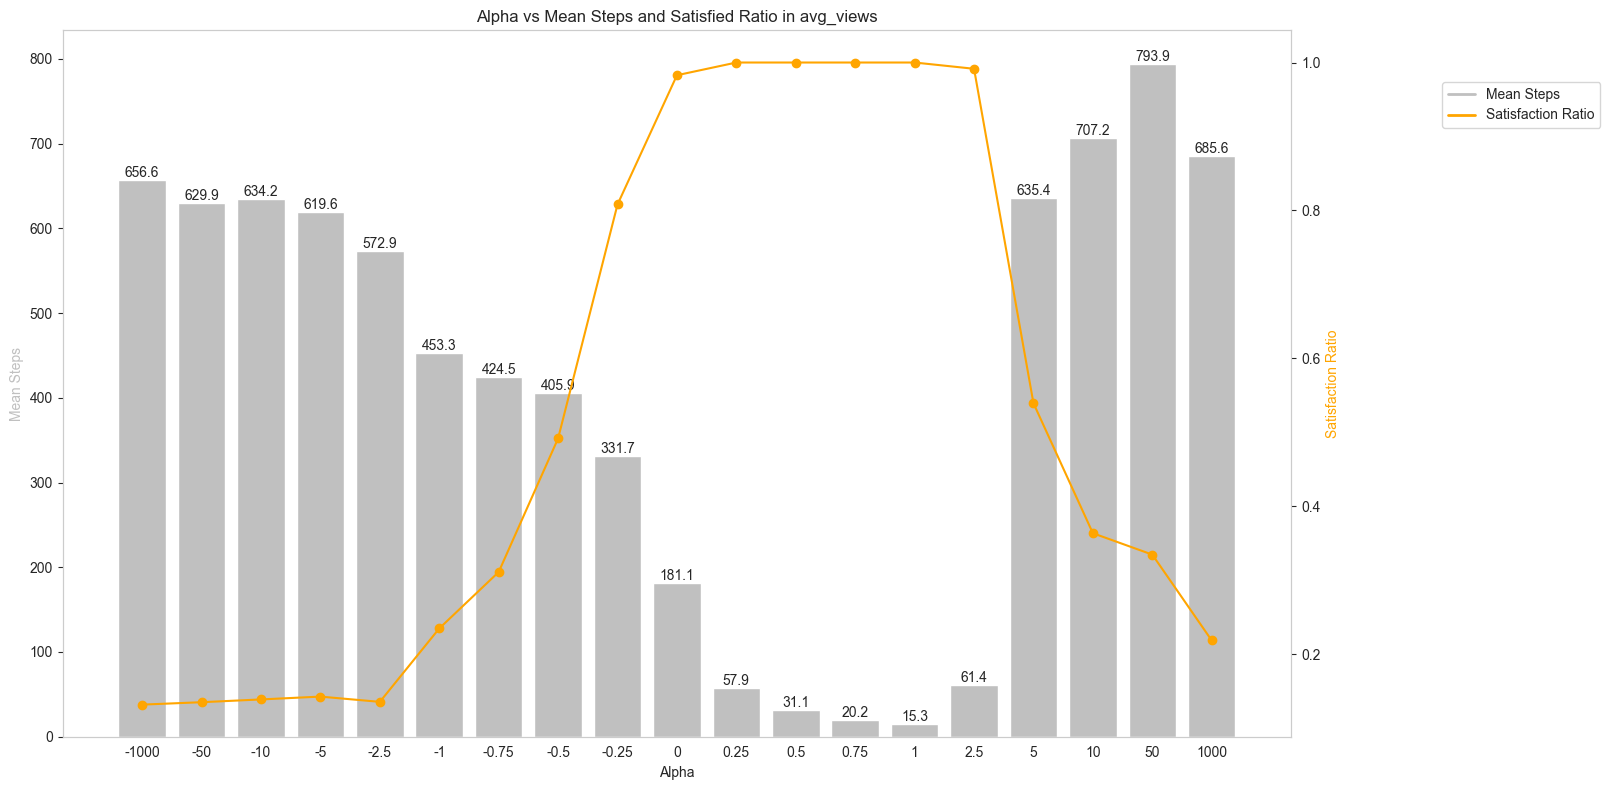

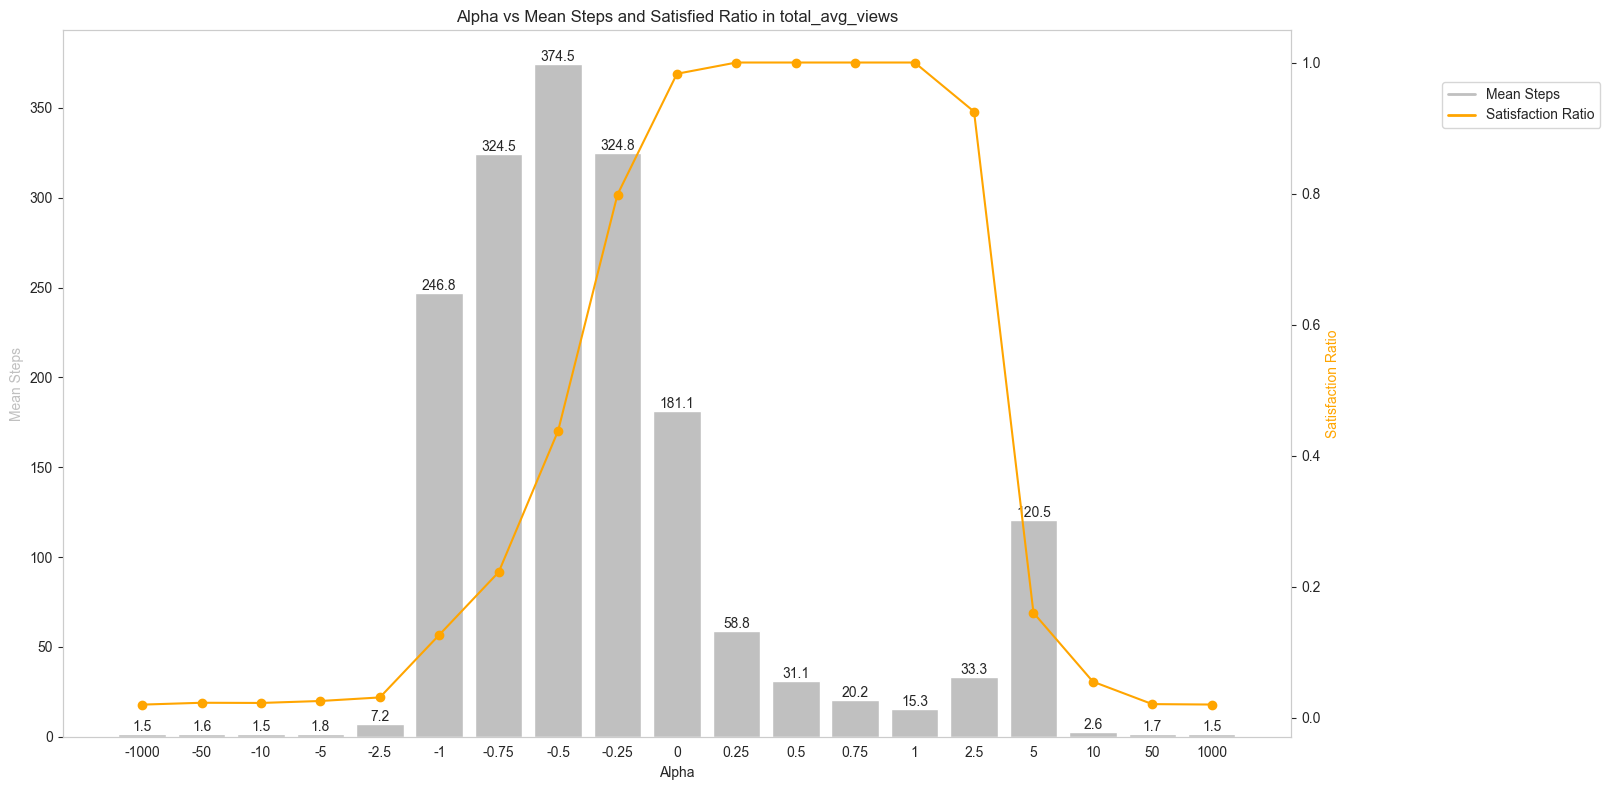

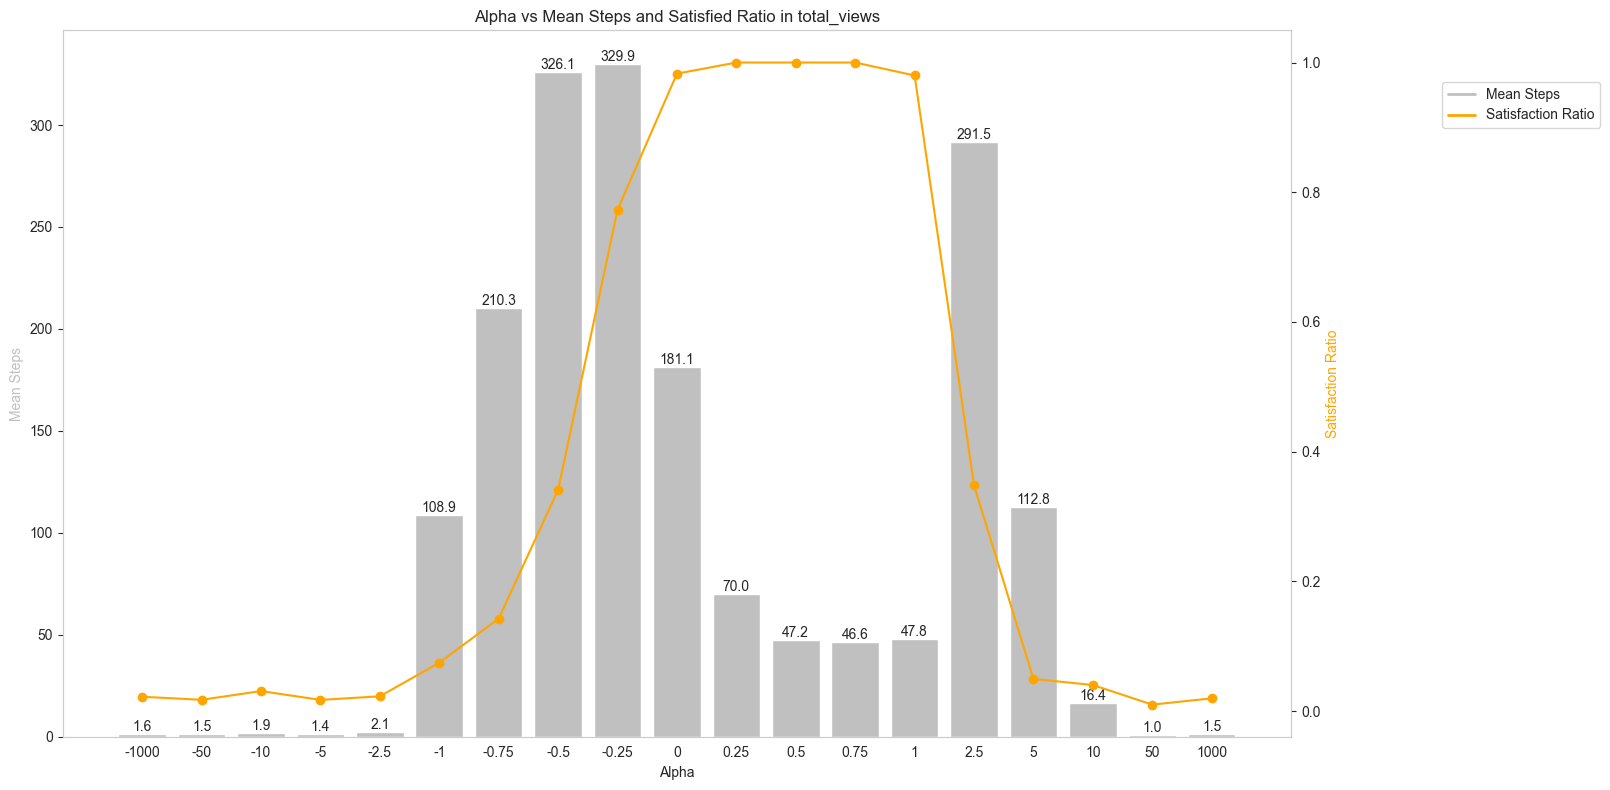

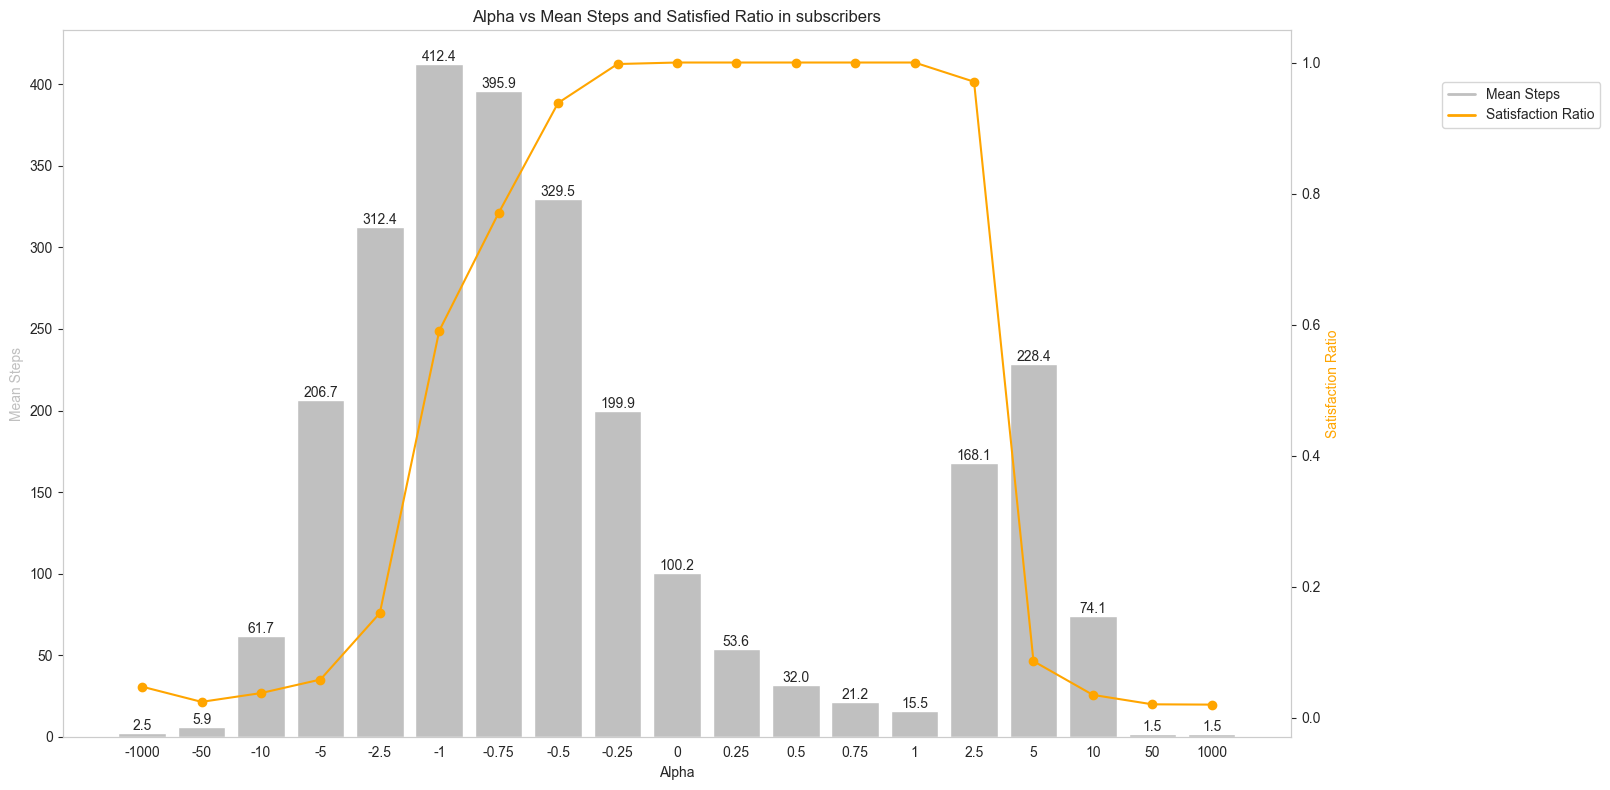

In [9]:
# Choose one model results to do further analysis
# [avg_view_output_files, total_avg_view_output_files, total_view_output_files, validate_output_files]
# Plot satisfaction on by one
res = [res_avg_view, res_total_avg_view, res_total_view, res_validate]
for i in res:
    plot_user_satisfaction_one(i)

In [10]:
def plot_comparison_of_two_datasets(dataset1, dataset2):
    """
    Plot a comparison of two datasets on the same plot with bar and line charts.
    @param dataset1: First dataset
    @param dataset2: Second dataset
    """
    fig, ax1 = plt.subplots(figsize=(14, 6))

    # Processing for dataset1
    user_all_1 = dataset1[0]
    alpha_stats_1 = process_dataset(user_all_1)

    # Processing for dataset2
    user_all_2 = dataset2[0]
    alpha_stats_2 = process_dataset(user_all_2)

    # Bar plot settings
    bar_width = 0.35
    bar_color1 = 'silver'
    bar_color2 = 'orange'

    # Line plot settings
    line_color1 = 'silver'
    line_color2 = 'orange'

    # Plotting bars for dataset1
    for i, (alpha, mean_steps) in enumerate(zip(alpha_stats_1['alpha'], alpha_stats_1['mean_steps'])):
        ax1.bar(i - bar_width / 2, mean_steps, bar_width, color=bar_color1, label='Dataset1 Mean Steps' if i == 0 else '')
        ax1.text(i - bar_width / 2, mean_steps, f'{mean_steps:.0f}', ha='center', va='bottom')

    # Plotting bars for dataset2
    for i, (alpha, mean_steps) in enumerate(zip(alpha_stats_2['alpha'], alpha_stats_2['mean_steps'])):
        ax1.bar(i + bar_width / 2, mean_steps, bar_width, color=bar_color2, label='Dataset2 Mean Steps' if i == 0 else '')
        ax1.text(i + bar_width / 2, mean_steps, f'{mean_steps:.0f}', ha='center', va='bottom')

    # Set labels and title
    ax1.set_xlabel('Alpha')
    ax1.set_ylabel('Mean Steps')
    # ax1.set_title('Comparison of Two Datasets')
    ax1.set_xticks(range(len(alpha_stats_1['alpha'])))
    ax1.set_xticklabels(alpha_stats_1['alpha'])

    # Plot line for dataset1
    ax2 = ax1.twinx()
    ax2.plot(alpha_stats_1['alpha'], alpha_stats_1['non_nan_ratio'], color=line_color1, marker='o', label='Dataset1 Satisfaction Ratio')

    # Plot line for dataset2
    ax2.plot(alpha_stats_2['alpha'], alpha_stats_2['non_nan_ratio'], color=line_color2, marker='o', label='Dataset2 Satisfaction Ratio')

    # Set labels for the second y-axis
    ax2.set_ylabel('Satisfaction Ratio')
    ax1.grid(False)
    ax2.grid(False)

    # Define custom legend labels and colors
    legend_labels = ['AVM Simulations', 'Baseline simulations']
    legend_colors = [bar_color1, bar_color2]
    custom_legend_handles = [Line2D([0], [0], color=color, lw=2) for color in legend_colors]

    # Create a legend
    fig.legend(custom_legend_handles, legend_labels, loc='upper left', bbox_to_anchor=(0.9, 0.9))
    plt.tight_layout(rect=[0, 0, 0.9, 1])
    plt.show()

def process_dataset(user_all):
    """
    Process a dataset to calculate mean steps and non-NaN ratio.
    """
    prop = lambda x: x.notna().sum() / len(x) if x.notna().any() else 0
    mu = lambda x: x.mean() if x.notna().any() else -1
    alpha_stats = user_all.groupby('alpha')['steps'].agg([mu, prop]).reset_index()
    alpha_stats.columns = ['alpha', 'mean_steps', 'non_nan_ratio']
    alpha_stats['f_alpha'] = alpha_stats['alpha'].astype(float)
    alpha_stats = alpha_stats.sort_values(by='f_alpha')
    return alpha_stats

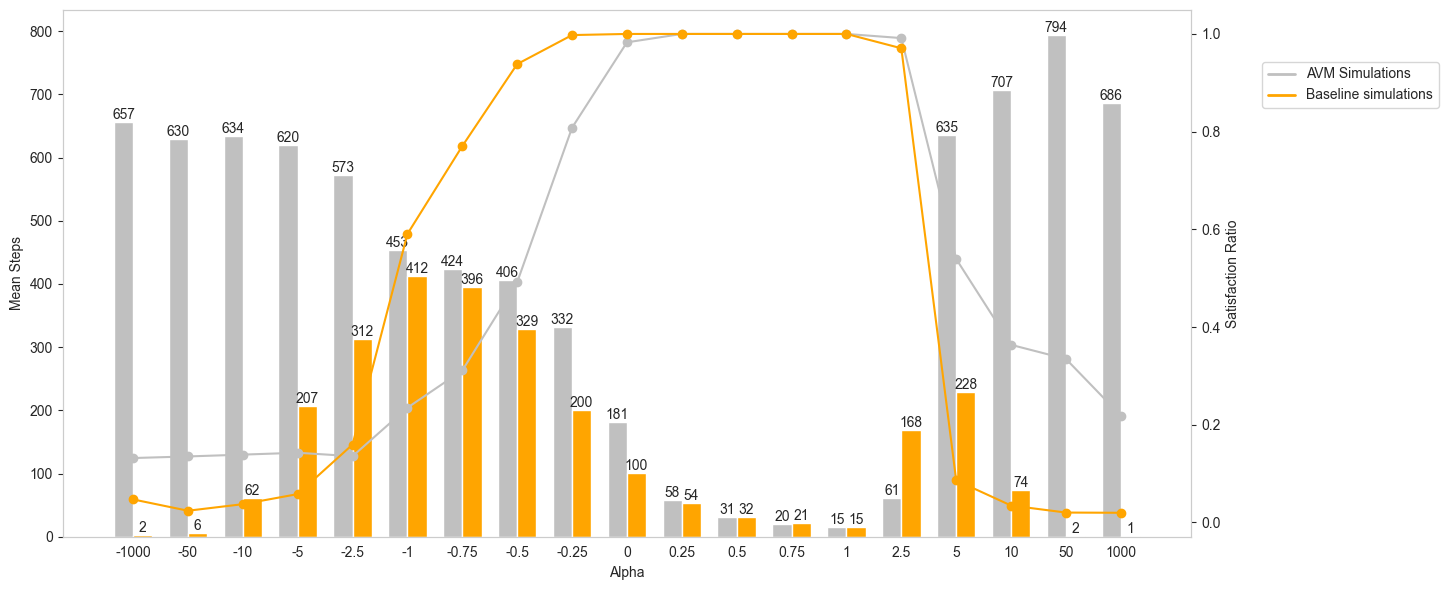

In [11]:
plot_comparison_of_two_datasets(res_avg_view, res_validate)

## Analysis of CCs' fairness
The individual Fairness of the CCs.

In [12]:
def cc_fair(res):
    """
    Get the proportions of individual fairness based on total_views,subscribers and avg_views. The input values in [res_avg_view, res_total_avg_view, res_total_view, res_validate]
    @param res: the list of DataFrames of processed outputs [user_all, cc_all]
    @return: DataFrame of values of alphas, ids, proportions of IF
    """
    cc_all = res[1]
    cc_all['rk_total_views'] = cc_all.groupby(['iteration', 'alpha'])['view'].rank(ascending=False)
    cc_all['rk_subscribers'] = cc_all.groupby(['iteration', 'alpha'])['subs'].rank(ascending=False)
    cc_all['rk_avg_views'] = cc_all.groupby(['iteration', 'alpha'])['avg_view'].rank(ascending=False)

    cc_all['IF_total_views'] = cc_all['rk_total_views']-1 <= cc_all['id']
    cc_all['IF_subscribers'] = cc_all['rk_subscribers']-1 <= cc_all['id']
    cc_all['IF_avg_views'] = cc_all['rk_avg_views']-1 <= cc_all['id']
    fair_ratio = cc_all.groupby(['alpha', 'id'])[['IF_total_views','IF_subscribers', 'IF_avg_views']].mean().reset_index()
    fair_ratio['alpha'] = fair_ratio['alpha'].astype(float)
    return fair_ratio

In [13]:
# palette definition based on alpha
alpha_list = [-1000, -50, -10, -5.0, -2.5, -1.0, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1, 2.5, 5, 10, 50, 1000]
palette = sns.color_palette('PuBu', 10)[1:][::-1]+ ['#D3D3D3']+ sns.color_palette('OrRd', 10)[1:]
palette = {a:palette[i] for i, a in enumerate(alpha_list)}

alpha_anti = [-1000, -50, -10, -5, -2.5, -1, -0.75, -0.5, -0.25, 0]
alpha_UR = [-1, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1]
alpha_PA = [0, 0.25, 0.5, 0.75, 1, 2.5, 5, 10, 50, 1000]

In [14]:
# get the IF date of all simulation models
IF_avg = cc_fair(res_avg_view)
IF_total = cc_fair(res_total_view)
IF_sub = cc_fair(res_validate)
IF_tavg = cc_fair(res_total_avg_view)

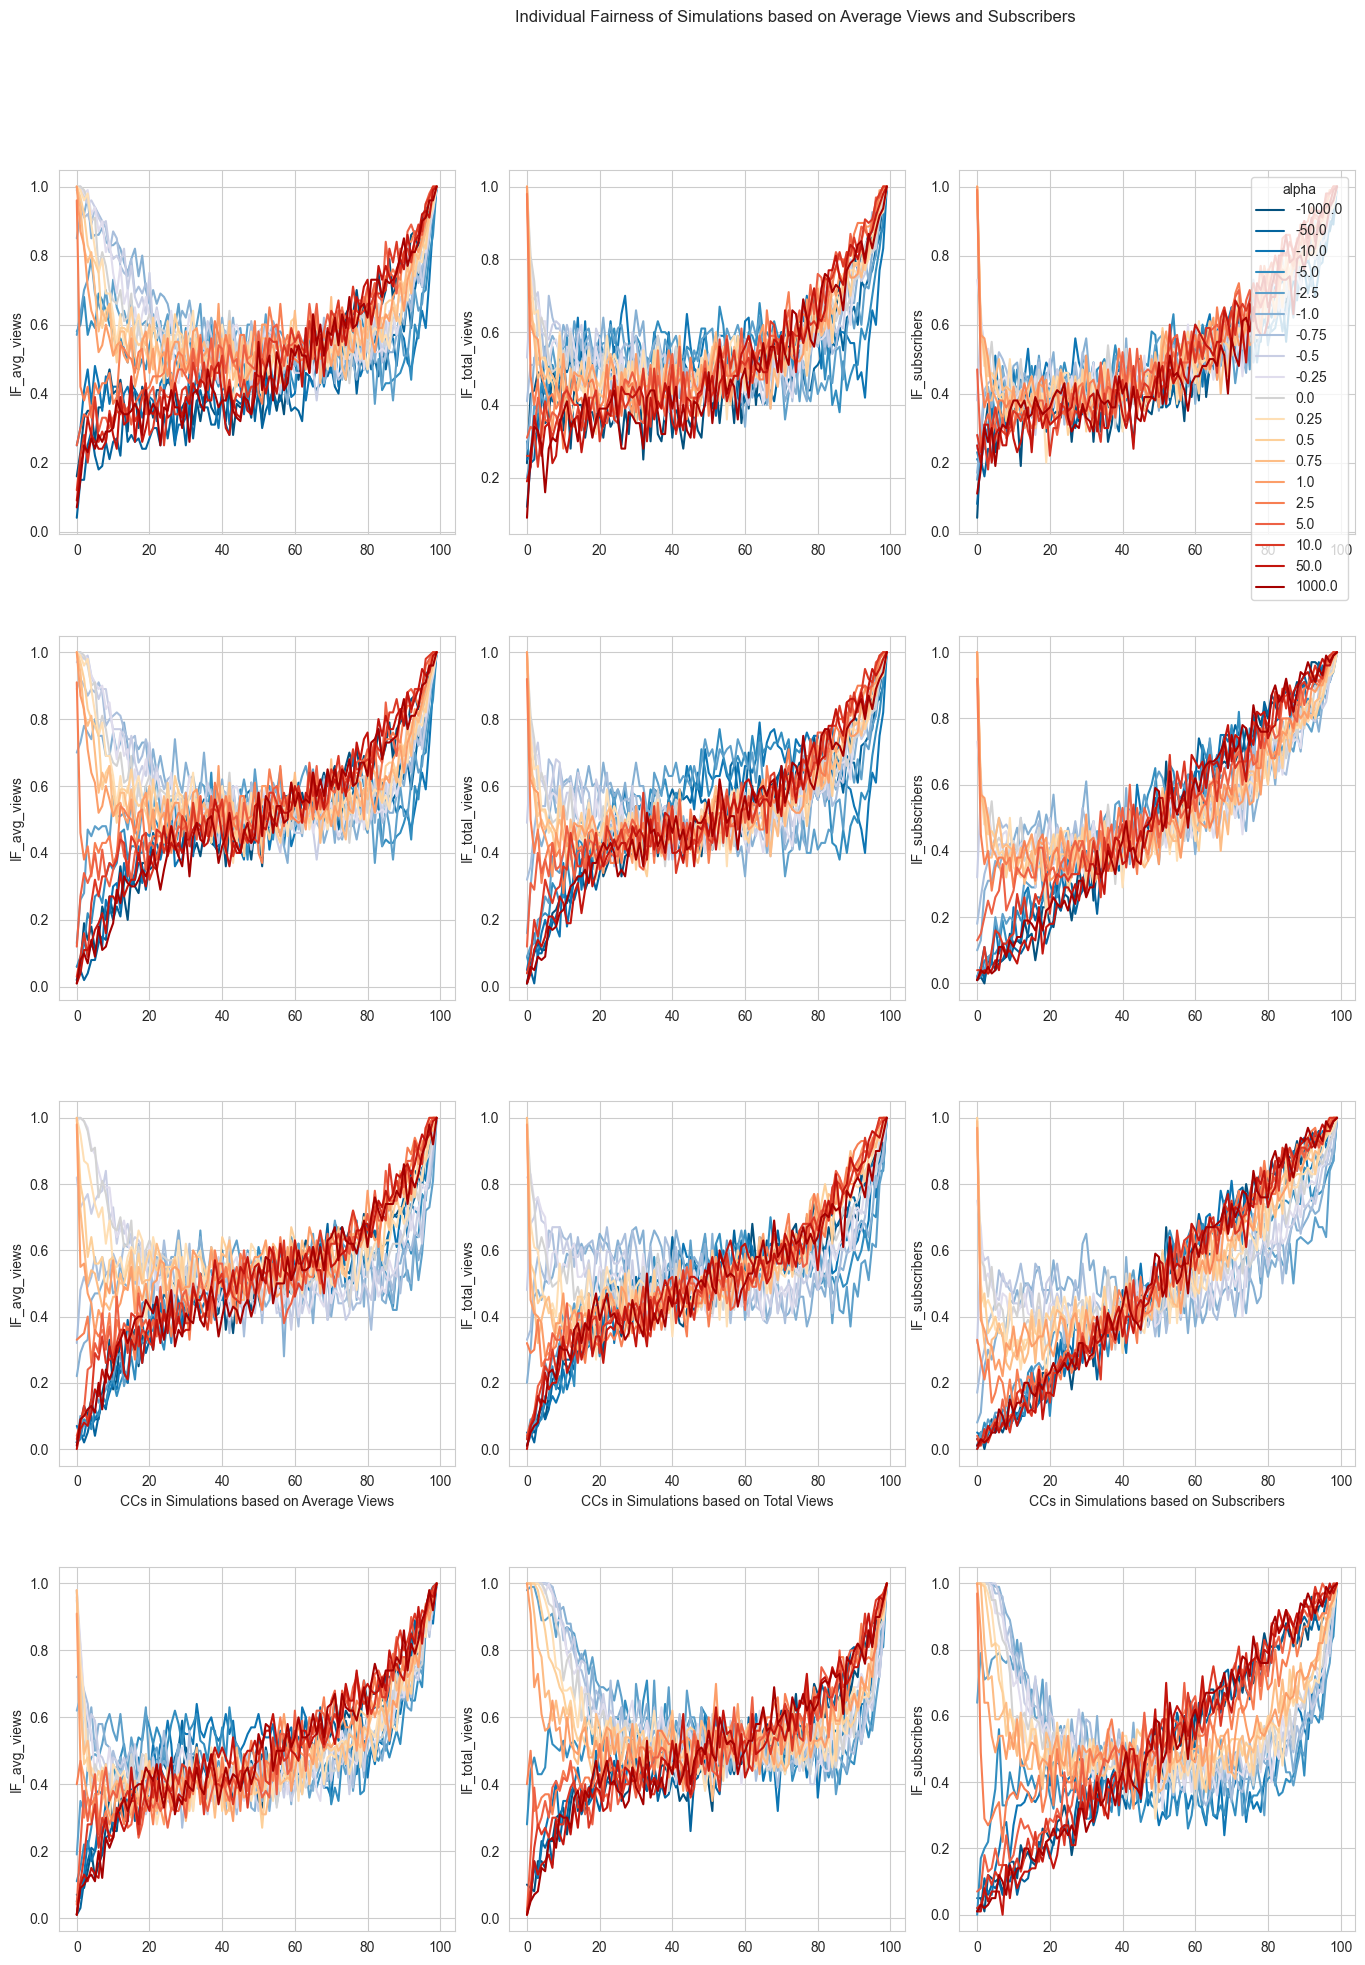

In [15]:
# plot the compare of 3 IFs for 4 simulations
def plot_fairness_all(if_to_compare, fair_eval, simu_basic):
    fig, axes = plt.subplots(4, 3, figsize=(16, 20))

    # Loop through each row and model
    for row, IF in enumerate(if_to_compare):
        # 4 simulations
        for col, fair_base in enumerate(fair_eval):
            if row < 4:  # 3 rows
                # Filter the dataframe
                filtered_fair = IF[IF['alpha'].isin(alpha_list)]
                # Plot on the appropriate subplot
                # plot(filtered_fair, 'alpha', 'id', 'IF_avg_views', axes[row, col])
                sns.lineplot(
                    data=filtered_fair,
                    x='id',
                    y=fair_eval[col],
                    ax=axes[row, col],
                    hue='alpha',
                    palette=palette)
                if row == 2:
                    axes[row, col].set_xlabel(f'CCs in Simulations based on {simu_basic[col]}')
                else: axes[row, col].set_xlabel('')
                axes[row, col].set_ylabel(fair_eval[col])
                # axes[row, col].set_title(f'The proportion of IF for each CC quality')
                if col == 2 and row == 0:
                    axes[row, col].legend(title='alpha')
                else: axes[row, col].legend([],[],frameon=False)
    fig.suptitle('Individual Fairness of Simulations based on Average Views and Subscribers')
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.subplots_adjust(right=0.85)
    # Show the plot
    plt.show()


fair_eval = ['IF_avg_views', 'IF_total_views', 'IF_subscribers']
simu_basic = ['Average Views', 'Total Views', 'Subscribers']
if_to_compare = [IF_avg, IF_tavg, IF_total, IF_sub]
plot_fairness_all(if_to_compare, fair_eval, simu_basic)

In [17]:
x = ['a', 'b', 'c']
def plot_fairness_compare(if_to_compare, fair_eval, simu_basic):
    """
    plot the compare of IF for two simulations
    @param if_to_compare: a list of two IF dataframes. [IF_avg, IF_sub]
    @param fair_eval: list of the columns in if_to_compare to be compared.
                    ['IF_avg_views', 'IF_subscribers']
    @param simu_basic: The basic of IF calculated in the columns. ['Average Views', 'Subscribers']
    @return: plots show 3x2 subplots compared two simulations IF
    """

    fig, axes = plt.subplots(3, 2, figsize=(12, 12))

    # Loop through each row and model
    for row, alpha_list in enumerate([alpha_anti, alpha_UR, alpha_PA]):
        # Ensure that we don't go out of bounds for the number of columns
        for col, IF in enumerate(if_to_compare):
            if row < 3:  # We only have 2 rows, not 3
                # Filter the dataframe
                filtered_fair = IF[IF['alpha'].isin(alpha_list)]
                # Plot on the appropriate subplot
                # plot(filtered_fair, 'alpha', 'id', 'IF_avg_views', axes[row, col])
                sns.lineplot(
                    data=filtered_fair,
                    x='id',
                    y=fair_eval[col],
                    hue='alpha',
                    ax=axes[row, col],
                    palette=palette)
                # if row == 2:
                    # axes[row, col].set_xlabel(f'CCs in Simulations based on {simu_basic[col]}')
                # else: axes[row, col].set_xlabel('')
                axes[row, col].set_xlabel(f'{x[row]}{col+1}')
                axes[row, col].set_ylabel('')
                # axes[row, col].set_ylabel(fair_eval[col])
                # axes[row, col].set_title(f'The proportion of IF for each CC quality')
                if col == 1:
                    axes[row, col].legend(title='alpha')
                else: axes[row, col].legend([],[],frameon=False)
    # fig.suptitle('Individual Fairness of Simulations with Average Views based on Average Views and Subscribers')
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.subplots_adjust(right=0.85)
    # Show the plot
    plt.show()


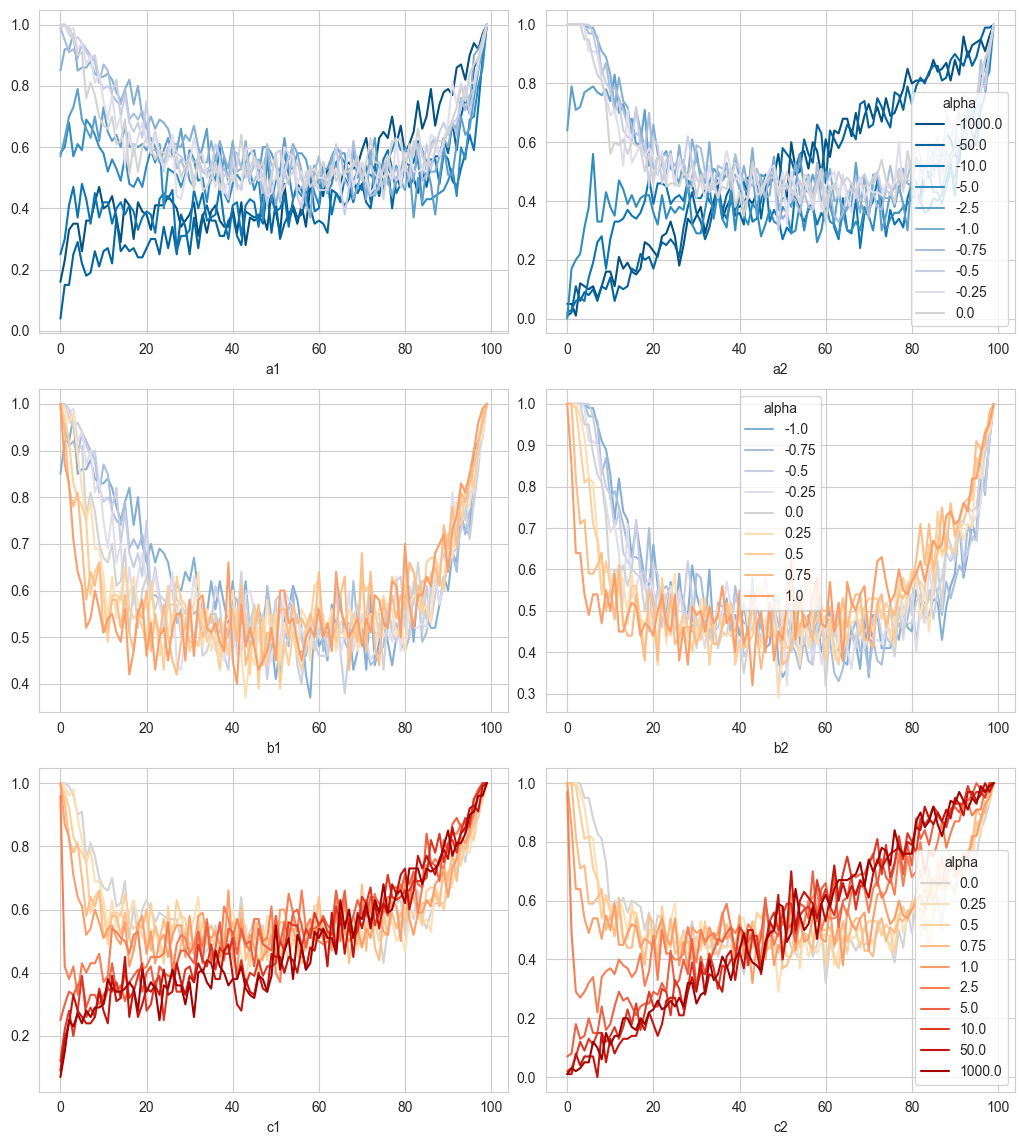

In [18]:
# according methods to evaluate the individual fairness
fair_eval = ['IF_avg_views', 'IF_subscribers']
simu_basic = ['Average Views', 'Subscribers']
if_to_compare = [IF_avg, IF_sub]

# other two simulations
# fair_eval = ['IF_avg_views', 'IF_total_views']
# simu_basic = ['Average Views', 'Total Views']
# if_to_compare = [IF_tavg, IF_total]
plot_fairness_compare(if_to_compare, fair_eval, simu_basic)

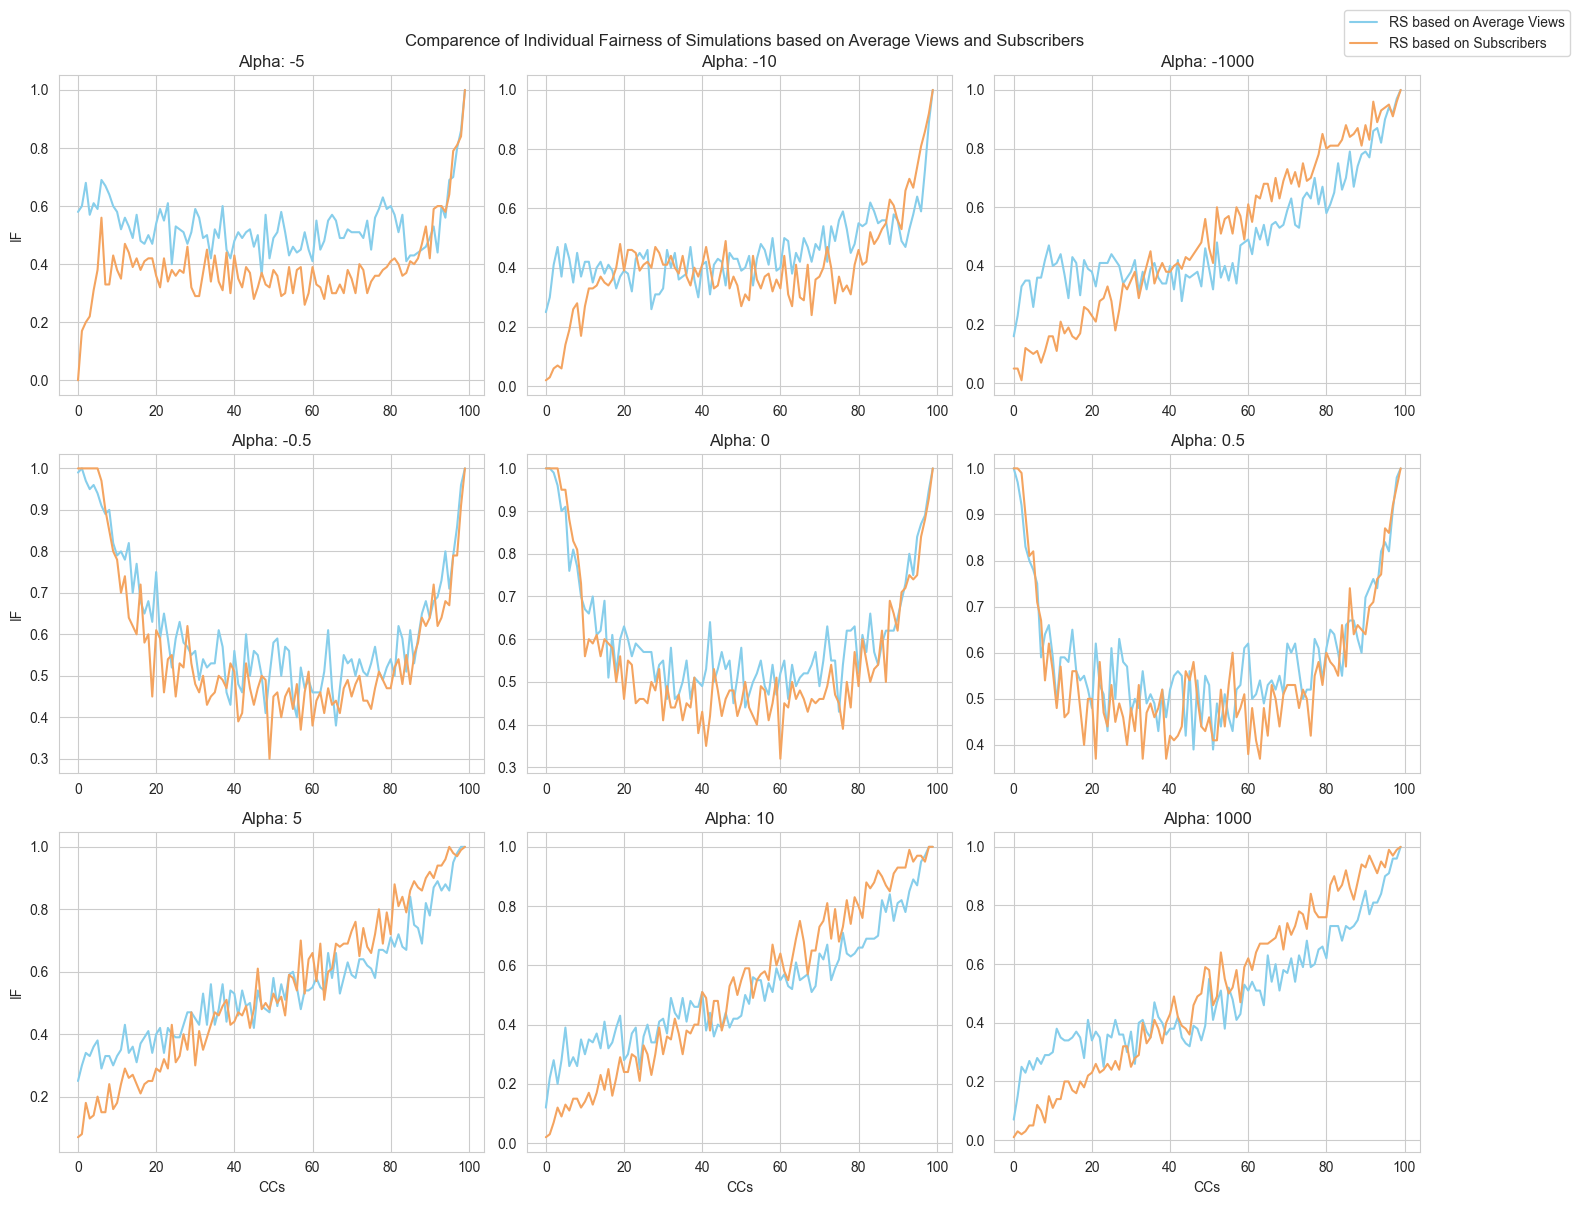

In [16]:
# Presuming IF_avg and IF_sub are pandas DataFrames that contain 'alpha', 'id' columns,
# along with 'IF_avg_views' and 'IF_subscribers' columns respectively.
import matplotlib.lines as mlines

alpha_values = [[-5, -10, -1000], [-0.5, 0, 0.5], [5, 10, 1000]]
fig, axes = plt.subplots(3, 3, figsize=(15, 12))  # Creating a 3x3 grid of subplots

# Loop through the rows and columns of your alpha values
lines = []
for i, row_values in enumerate(alpha_values):
    for j, alpha in enumerate(row_values):
        # Filter the data for the current alpha value
        df_avg = IF_avg[IF_avg['alpha'] == alpha]
        df_sub = IF_sub[IF_sub['alpha'] == alpha]

        # Assuming 'id' is a common column that you can use to merge/join both dataframes
        # merged_df = df_avg.merge(df_sub, on='id', suffixes=('_avg', '_sub'))

        # Now plot using seaborn's lineplot on the appropriate subplot axis
        line1 = sns.lineplot(
            ax=axes[i, j],
            data=df_avg, x='id',
            y='IF_avg_views',
            color='skyblue',
        )
        line2 = sns.lineplot(
            ax=axes[i, j],
            data=df_sub, x='id',
            y='IF_subscribers',
            color='sandybrown',
        )
        axes[i, j].set_title(f'Alpha: {alpha}')
        if i == 2:
            axes[i, j].set_xlabel('CCs')
        else:
            axes[i, j].set_xlabel('')
        if j == 0:
            axes[i, j].set_ylabel('IF')
        else:
            axes[i, j].set_ylabel('')
        # if i == 0 and j == 0:
lines.append(mlines.Line2D([], [], color='skyblue',  label='RS based on Average Views'))
lines.append(mlines.Line2D([], [], color='sandybrown', label='RS based on Subscribers'))


plt.figlegend(
    handles= lines,
    # labels=['Avg Views', 'Subscribers'],
    loc='upper right',
    bbox_to_anchor=(1.05, 1),
    borderaxespad=0.
)
fig.suptitle('Comparence of Individual Fairness of Simulations based on Average Views and Subscribers')

plt.tight_layout()
# plt.subplots_adjust(top=0.9)
plt.subplots_adjust(right=0.95)
plt.show()

## Validation

Describe the correlation between frequency, quality and # of followers

In [19]:
res = [res_avg_view, res_total_avg_view, res_total_view, res_validate]

/Users/gee/PycharmProjects/Fairness-for-SMI/venv/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/gee/PycharmProjects/Fairness-for-SMI/venv/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/gee/PycharmProjects/Fairness-for-SMI/venv/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


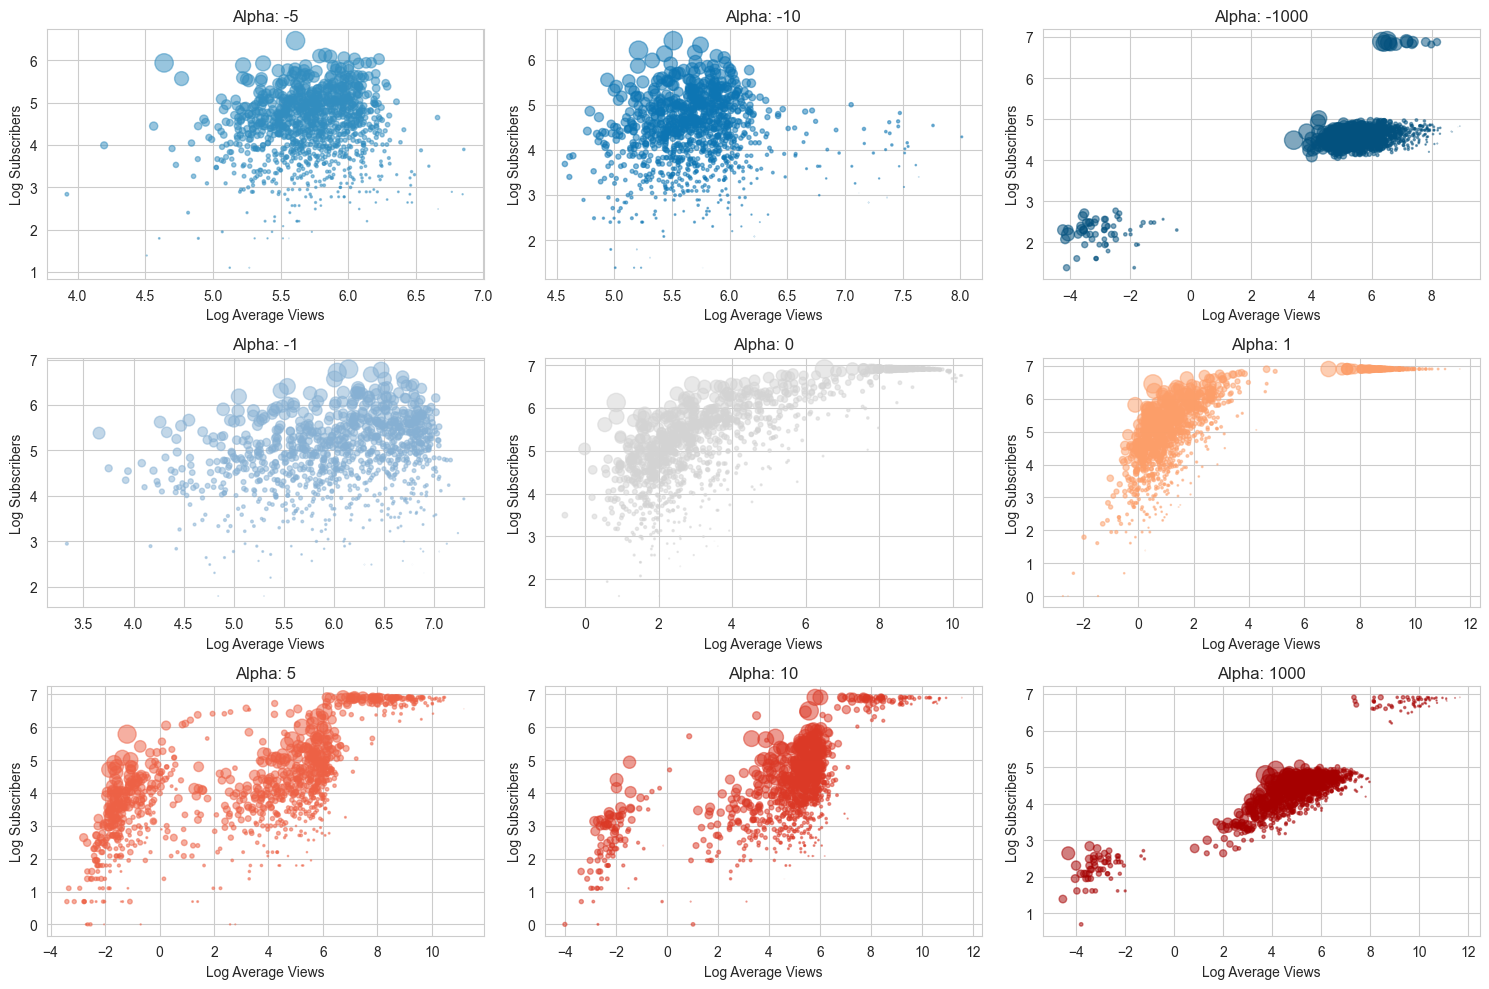

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def plot_log_subs_avgview(df, alphas):
    # Create a color palette
    # palette = sns.color_palette("hsv", len(alphas))
    df['falpha'] = df['alpha'].astype(float)
    df = df[df['id']<10]

    # Create a 3x3 subplot grid
    fig, axes = plt.subplots(3, 3, figsize=(15, 10))
    axes = axes.flatten()  # Flatten the array for easy iteration

    for i, alpha in enumerate(alphas):
        # Select the subset of data for the current alpha
        df_filtered = df[df['falpha'] == alpha]

        # Plot on the ith subplot
        ax = axes[i]
        scatter = ax.scatter(np.log(df_filtered['avg_view']), np.log(df_filtered['subs']),
                             s=df_filtered['frequency'], alpha=0.5, color=palette[alpha])

        # Set titles and labels
        ax.set_title(f'Alpha: {alpha}')
        ax.set_xlabel('Log Average Views')
        ax.set_ylabel('Log Subscribers')

    # Adjust the layout
    plt.tight_layout()
    plt.show()

# Example usage with a list of alpha values
alphas = [ -5, -10,-1000, -1, 0, 1, 5, 10, 1000]
plot_log_subs_avgview(res_avg_view[1], alphas)

/Users/gee/PycharmProjects/Fairness-for-SMI/venv/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


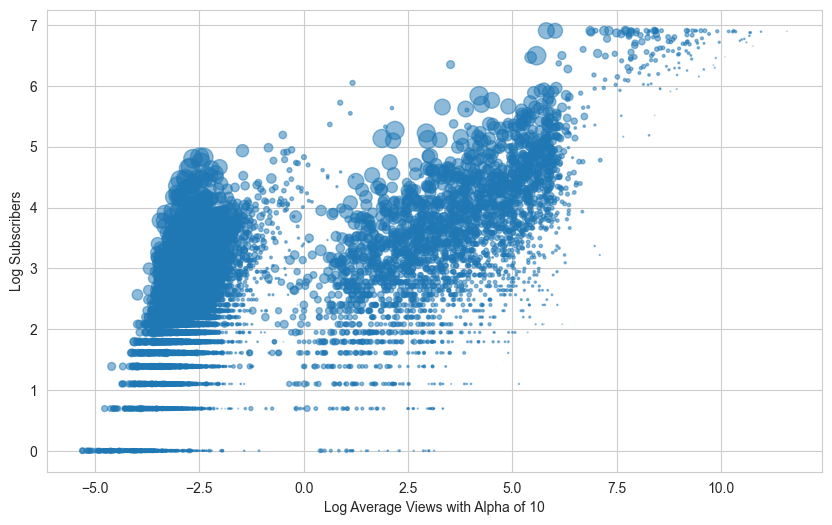

In [21]:
def plot_log_subs_avgview(df, alpha):
    df['falpha'] = df['alpha'].astype(float)
    df = df[df['falpha']==alpha]
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(np.log(df['avg_view']), np.log(df['subs']), s=df['frequency'], alpha=0.5)  # Multiplying freq_m to adjust bubble size

    # Adding titles and labels
    # plt.title('Log-log Plot of Average Views vs. Subscribers')
    plt.xlabel(f'Log Average Views with Alpha of {alpha}')
    plt.ylabel('Log Subscribers')
    # plt.colorbar(scatter, label='Frequency per Month (Size of Bubble)')
    # Show plot
    plt.show()
plot_log_subs_avgview(res_avg_view[1], 10)